## Выявление закономерностей определяющих успешность игры

Описание проекта: Интернет-магазину «Стримчик», который продаёт по всему миру компьютерные игры, нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.


Источник данных: Исторические данные о продажах игр, оценках пользователей и экспертов, жанрах и платформах из открытых источников

## Изучение данных из файла

Подключим все нужные библиотеки

In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st

Создадим датафрейм и посмотрим информацию о нем. Выведем несколько строк

In [2]:
games = pd.read_csv('/datasets/games.csv')

In [3]:
display(games.head(10))
games.info()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
6,New Super Mario Bros.,DS,2006.0,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E
7,Wii Play,Wii,2006.0,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E
8,New Super Mario Bros. Wii,Wii,2009.0,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
Name               16713 non-null object
Platform           16715 non-null object
Year_of_Release    16446 non-null float64
Genre              16713 non-null object
NA_sales           16715 non-null float64
EU_sales           16715 non-null float64
JP_sales           16715 non-null float64
Other_sales        16715 non-null float64
Critic_Score       8137 non-null float64
User_Score         10014 non-null object
Rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


Заменим названия столбцов на корректные

In [4]:
games.columns = ['name', 'platform', 'year_of_release', 'genre',\
                 'na_sales', 'eu_sales', 'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating']

Заменим Год выпуска на корректный. Во всех остальных случаях нужна дробная часть

In [5]:
games['year_of_release'] = pd.to_datetime(games['year_of_release'], format='%Y')
games['year_of_release'] = games['year_of_release'].dt.year

Столбец рейтинг пользователей почему-то строкой. Узнаем почему

In [6]:
games['user_score'].value_counts()

tbd    2424
7.8     324
8       290
8.2     282
8.3     254
       ... 
1.9       2
0.6       2
9.6       2
0         1
9.7       1
Name: user_score, Length: 96, dtype: int64

tbd означает, что рейтинг не определен. Сделаем его nan и поменяем тип данных.

In [7]:
games['user_score'] = games['user_score'].replace("tbd", float("nan")).astype('Float64')

Теперь обработаем пропуски в данных. Посмотрим каких пропусков маленький процент и удалим их

In [8]:
games.isna().sum() / len(games) * 100

name                0.011965
platform            0.000000
year_of_release     1.609333
genre               0.011965
na_sales            0.000000
eu_sales            0.000000
jp_sales            0.000000
other_sales         0.000000
critic_score       51.319174
user_score         54.591684
rating             40.478612
dtype: float64

In [9]:
games.dropna(subset=['name'], inplace=True)

In [10]:
games.dropna(subset=['year_of_release'], inplace=True)

В остальных случаях пропусков много. Есть вариант заменить рейтинг по продажам.

Посчитаем суммарные продажи и занесем в отдельный столбец

In [11]:
games['sales'] = games['na_sales'] + games['eu_sales'] + games['jp_sales'] + games['other_sales']

Попробуем привязать оценку критиков к продажам и проверим есть ли зависимость

In [12]:
print(games['sales'].corr(games['critic_score'].astype('Float64')))

0.24534884547411376


Корреляция очень слабая. Этот вариант не подойдет.

Остальных пропусков много, оставим так как есть

Теперь поставим рейтинг исходя из жанра игры. Сначала создадим словарь с самым популярным рейтингом каждой игры, а затем через функию добавим эти значение вместо пропусков

In [15]:
def genre_rating(data, genre, rating):
    top_rating = {}
    for genre_unique in data[genre].unique():
        top_rating[genre_unique] = data.loc[data[genre] == genre_unique, rating].value_counts().index[0]
    return top_rating

In [16]:
# Код ревьюера, для примера
games.groupby(['genre', 'rating'])['rating'].count()

genre         rating
Action        AO           1
              E          410
              E10+       468
              EC           1
              M          596
              T          670
Adventure     E          159
              E10+        67
              EC           2
              M           98
              T          114
Fighting      E            8
              E10+        19
              M           48
              T          357
Misc          E          449
              E10+       166
              EC           5
              K-A          1
              M           13
              T          228
Platform      E          354
              E10+       141
              M            3
              T           63
Puzzle        E          284
              E10+        42
              T           10
Racing        E          576
              E10+        95
              M           18
              T          167
Role-Playing  E           83
              E10+    

In [17]:
top_rating = genre_rating(games, 'genre', 'rating')

In [18]:
display(top_rating)

{'Sports': 'E',
 'Platform': 'E',
 'Racing': 'E',
 'Role-Playing': 'T',
 'Puzzle': 'E',
 'Misc': 'E',
 'Shooter': 'M',
 'Simulation': 'E',
 'Action': 'T',
 'Fighting': 'T',
 'Adventure': 'E',
 'Strategy': 'T'}

In [19]:
def no_nan_rating(data, dict):
    for genre_unique in dict:
        data.loc[(data['rating'].isna()) & (data['genre'] == genre_unique), 'rating'] = dict[genre_unique]
    return data.head()

In [21]:
games['rating'] = games['rating'].fillna('unknown')

Рейтинг ESRB создавался для рынка Канады и США. Возможно пропуски означают, что игры создавались не для их рынка, а значит и рейтинг им не нужен. Заменил пропуски на unknown, чтобы видеть их на графиках

Сейчас проверим есть ли у нас некорректные названия

In [22]:
games['platform'].unique()

array(['Wii', 'NES', 'GB', 'DS', 'X360', 'PS3', 'PS2', 'SNES', 'GBA',
       'PS4', '3DS', 'N64', 'PS', 'XB', 'PC', '2600', 'PSP', 'XOne',
       'WiiU', 'GC', 'GEN', 'DC', 'PSV', 'SAT', 'SCD', 'WS', 'NG', 'TG16',
       '3DO', 'GG', 'PCFX'], dtype=object)

In [23]:
games['genre'].unique()

array(['Sports', 'Platform', 'Racing', 'Role-Playing', 'Puzzle', 'Misc',
       'Shooter', 'Simulation', 'Action', 'Fighting', 'Adventure',
       'Strategy'], dtype=object)

Теперь проверим на дубликаты

In [24]:
games.duplicated().sum()

0

## Исследовательский анализ

Посмотрим сколько игр выпускалось в разные годы. Посторим график

Text(0.5, 1.0, 'Количество игр по годам')

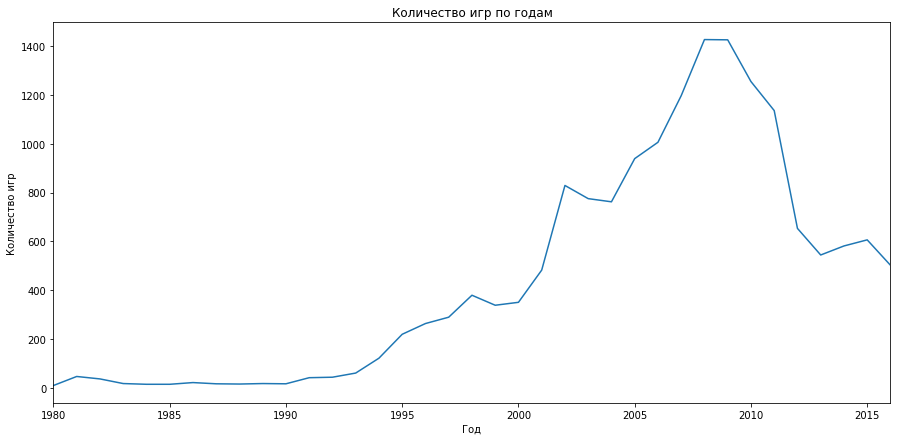

In [25]:
fig, ax = plt.subplots()
games.groupby('year_of_release')['year_of_release'].count().plot(figsize=(15, 7))

ax.set_xlabel('Год')
ax.set_ylabel('Количество игр')
ax.set_title('Количество игр по годам')

В 1995 году произошел скачок выпуска игр и их стало выпускаться намного больше, предположим это связано с быстрым развитием компьютерных тенологий.

Выберем 4 самых популярных платформы и посмотрим как долго они были популярны, построив гистограммы

In [26]:
games.pivot_table(index='platform', values='sales', aggfunc='sum')\
.sort_values(by='sales', ascending=False).reset_index().head(4)

,platform,sales
0,PS2,1233.56
1,X360,961.24
2,PS3,931.34
3,Wii,891.18


Text(0, 0.5, 'Продажи')

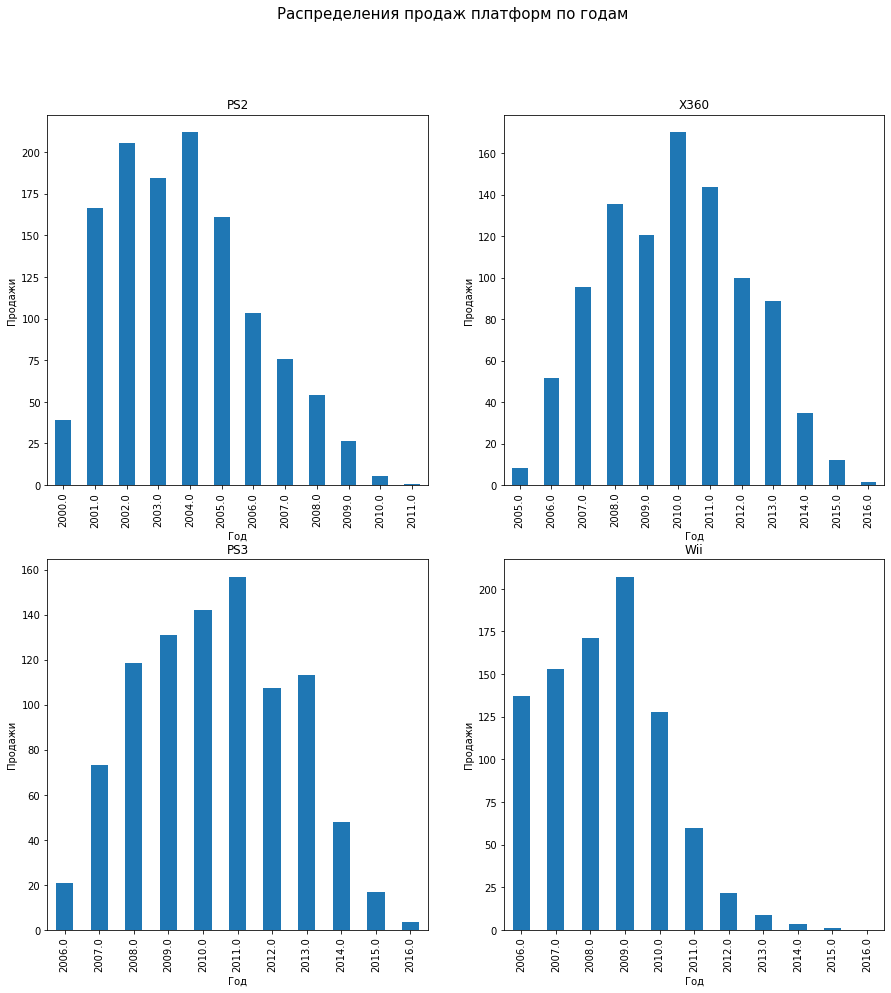

In [27]:
fig1 = plt.figure(figsize=(15, 15))
fig1.suptitle('Распределения продаж платформ по годам', fontsize=15)

plt.subplot(2, 2, 1).set_title('PS2')
games.query('platform == "PS2"').groupby('year_of_release')['sales'].sum().plot(kind='bar')
plt.xlabel('Год')
plt.ylabel('Продажи')

plt.subplot(2, 2, 2).set_title('X360')
games.query('platform == "X360"').groupby('year_of_release')['sales'].sum().plot(kind='bar')
plt.xlabel('Год')
plt.ylabel('Продажи')

plt.subplot(2, 2, 3).set_title('PS3')
games.query('platform == "PS3"').groupby('year_of_release')['sales'].sum().plot(kind='bar')
plt.xlabel('Год')
plt.ylabel('Продажи')

plt.subplot(2, 2, 4).set_title('Wii')
games.query('platform == "Wii"').groupby('year_of_release')['sales'].sum().plot(kind='bar')
plt.xlabel('Год')
plt.ylabel('Продажи')

На PS2 со страрта продаж игры продавались максимально и только спустя 5 лет пошел спад, после выхода PS3. Продажи игр на XBox360 росли плавно и к 2010 году достигли своего пика, после пошли на спад. Платформа была актуальна 9 лет. На PS3 продажа игр росла плавно, скорее всего из-за того, что многие еще пользовались PS2. Пик продаж в 2011. Платформа была актуальна так же 7 лет. Продажи игра на Wii росла очень плавна и достгла пика в 2009, затем пошел спад. Тут платформа продержалась 5 лет.
    Выбранные платформы были актуальны от 8-10 лет. А их продажи могут упасть с максимума до минимума за 3 года. В среднем на пике продажи держаться 5 лет

Если платформы на пике держаться в течении 5 лет, то возьмем данные за последние 4 года, чтобы прогнозировать. 5 лет большой срок, а за 2016 судя по графикам мы получили не полный отчет. Возьмем только с 2013 по 2016, так как остальные года нас не интересуют. Создадим новый датафрейм и возьмем 9 самых продаваемых платформ за это время.

In [29]:
actual = games.query('year_of_release > 2012')

In [30]:
actual['platform'].value_counts()

PS4     392
PSV     358
PS3     345
3DS     303
XOne    247
PC      189
X360    186
WiiU    115
PSP      67
Wii      23
DS        8
Name: platform, dtype: int64

In [31]:
top_platform = actual.pivot_table(index='platform', values='sales', aggfunc='sum')\
.sort_values(by='sales', ascending=False).reset_index().head(9)

С помощью функции посторим диаграммы распределения продаж по годам и посмотрим продажи каких игр идут на подъем, а какие на спад

In [32]:
def hist_platform(data, dict):
    fig2 = plt.figure(figsize=(15, 15))
    fig2.suptitle('Распределние продаж по годам')
    i = 0
    for dict_unique in dict['platform'].unique():
        i += 1
        plt.subplot(3, 3, i).set_title(dict_unique)
        data.loc[data['platform'] == dict_unique].groupby('year_of_release')['sales'].sum().plot(kind='bar')
        plt.xlabel('Год')
        plt.ylabel('Продажи')
        plt.subplots_adjust(hspace=0.4)
    return

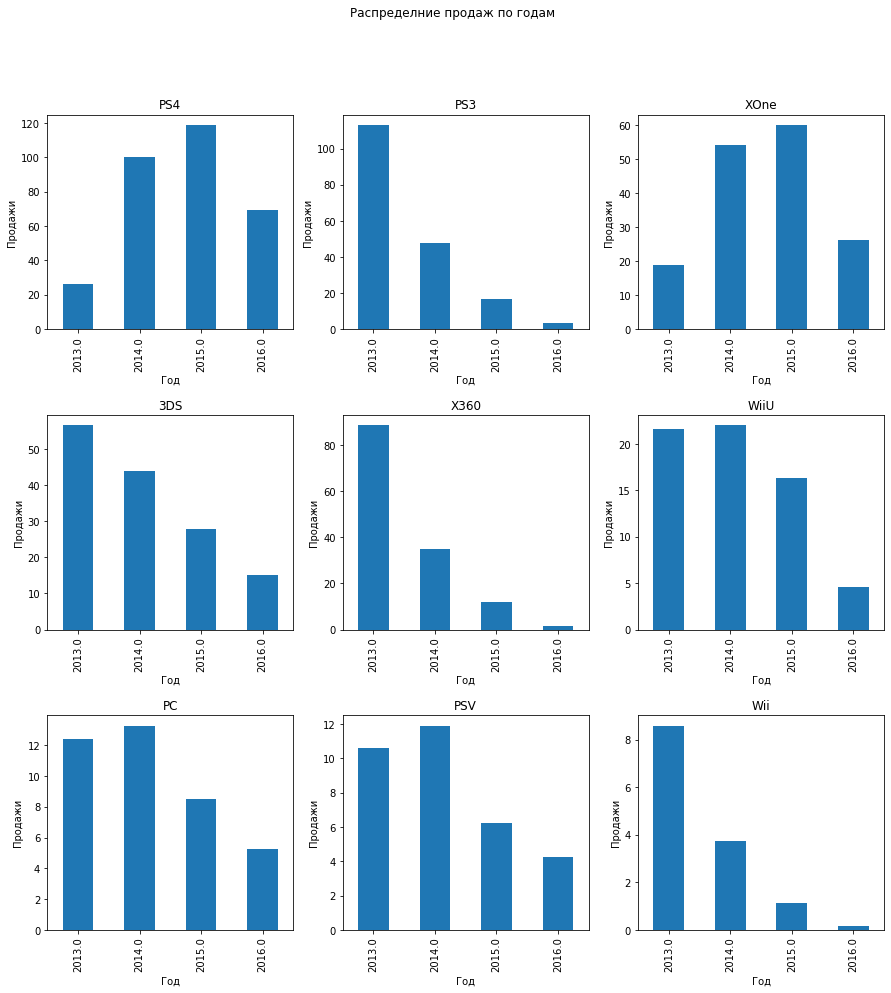

In [33]:
hist_platform(actual, top_platform)

PS3, X360, 3DS, Wii, WiiU, PC, PSV - продажи идут на спад. Продажи игр на PC плавно идут на подъем, но не так сильно как все остальные. Продажи игр на PS4 и XOne растут каждый год, эти платформы должны быть прибыльными и далее, так как они выходят только с 2013 года.

Теперь построим диаграмму размаха для каждой актуальной платформы

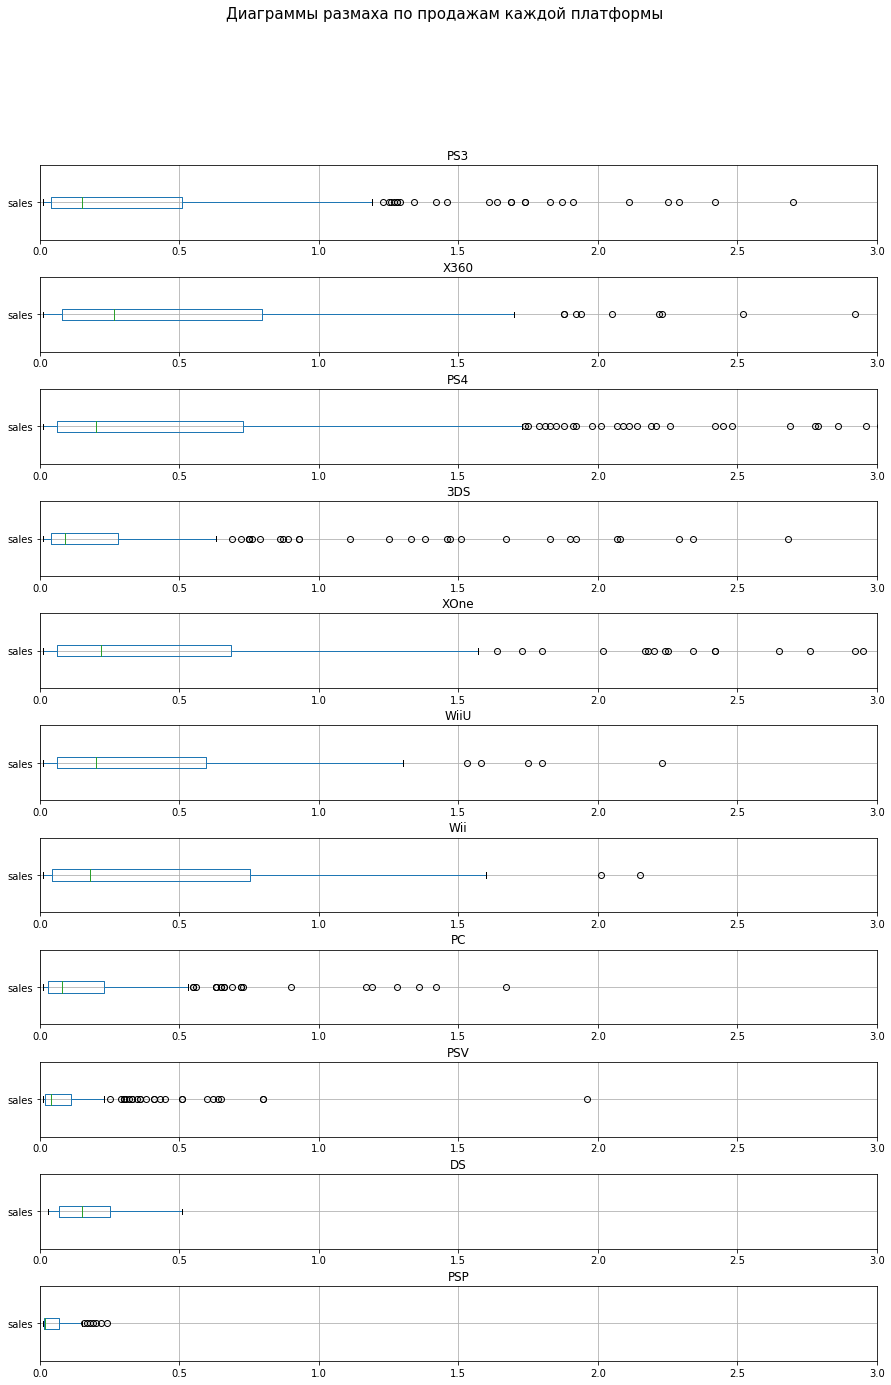

In [34]:
y = len(actual['platform'].unique())
i = 0
plt.figure(figsize=(15, 2*y)).suptitle('Диаграммы размаха по продажам каждой платформы', fontsize=15)
for platform_unique in actual['platform'].unique():
    i += 1
    plt.subplot(y, 1, i).set_title(platform_unique)
    actual.loc[actual['platform'] == platform_unique].boxplot('sales', vert=False)
    plt.xlim([0,3])
    plt.subplots_adjust(hspace=0.5)

Самые высокие медианы у X360, PS4, XOne. Высокие 75-й процентиль у X360, PS4, XOne, Wii, Wiiu. Это означает, что у этих платформ много игр с высокими продажами. нужно ориентироваться на них

По диаграммам размаха видим, что на каждой платформе много выбросов, эти выбросы это очень популярные игры, у которых продажи намного выше чем у всех остальных.

Теперь построим диаграмму рассеивания  отзывов и продаж для самой популярной актуальной платформы.

In [35]:
actual.pivot_table(index='platform', values='sales', aggfunc='sum').sort_values(by='sales', ascending=False).index[0]

'PS4'

Text(0.5, 1.0, 'Диаграмма рассеивание "оценки критиков-продажи" PS4')

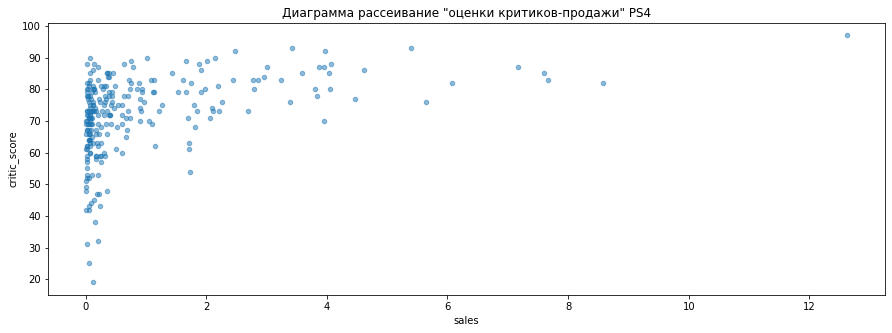

In [36]:
actual.query('platform =="PS4"').plot(x='sales', y='critic_score',\
                                      kind='scatter', alpha=0.5, figsize=(15,5)).set_title('critic score - sales')
plt.title('Диаграмма рассеивание "оценки критиков-продажи" PS4')

Text(0.5, 1.0, 'Диаграмма рассеивание "оценки пользователей-продажи" PS4')

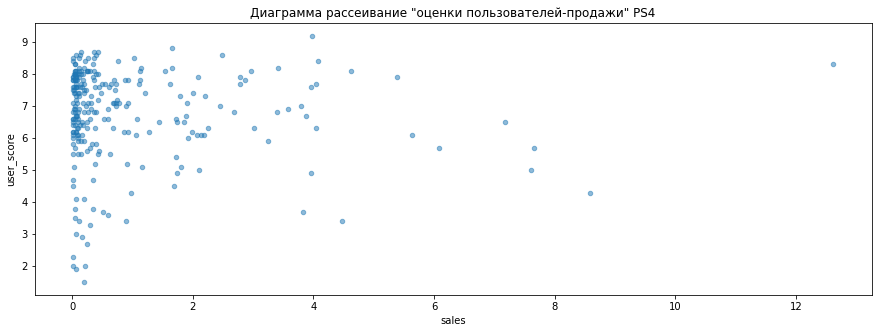

In [37]:
actual.query('platform =="PS4"').plot(x='sales', y='user_score', kind='scatter',\
                                      alpha=0.5, figsize=(15,5)).set_title('user score - sales')
plt.title('Диаграмма рассеивание "оценки пользователей-продажи" PS4')

Ни одна игра с низкой оценкой критиков не была успешной, но часто они ставят высокую оценку провалившимся в продажах играм. Оценка пользователей разная. Они тоже часто ставят высокую оценку играм, которые провалились в продажах. И заметно чаще ошибаются, поставив низкую оценку успешым играм

Теперь посмотрим есть ли зависимость между продажами и отзывами

In [38]:
actual.query('platform =="PS3"')['user_score'].corr(actual.query('platform =="PS3"')['sales'])

0.0023944027357566925

In [39]:
actual.query('platform =="PS3"')['critic_score'].astype('Float64').corr(actual.query('platform =="PS3"')['sales'])

0.3342853393371919

Видим, что зависимости между оценкаи пользователей и продажами нет, у критиков зависимость тоже слабая, но все таки выше чем у пользователей. Критики правильнее оценивают игры.

Теперь посмотрим эти же результаты для всех платформ

Text(0.5, 1.0, 'Диаграмма рассеивание "оценки критиков-продажи"')

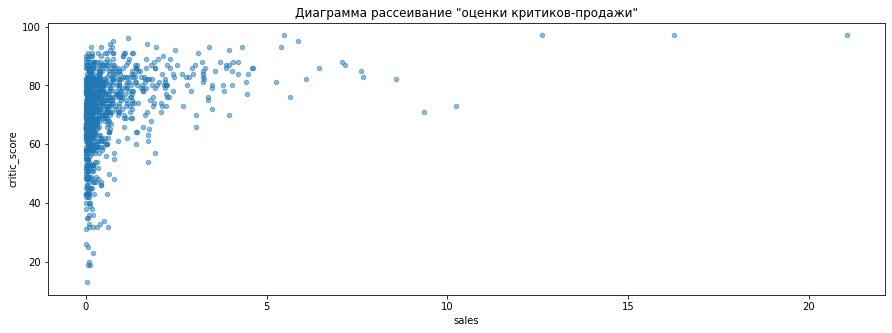

In [40]:
actual.plot(x='sales', y='critic_score', kind='scatter', alpha=0.5, figsize=(15,5)).set_title('critic score - sales')
plt.title('Диаграмма рассеивание "оценки критиков-продажи"')

Text(0.5, 1.0, 'Диаграмма рассеивание "оценки пользователей-продажи"')

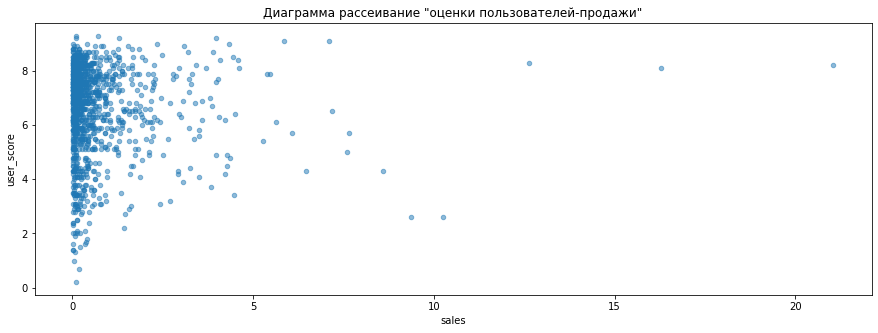

In [41]:
actual.plot(x='sales', y='user_score', kind='scatter', alpha=0.5, figsize=(15,5)).set_title('user score - sales')
plt.title('Диаграмма рассеивание "оценки пользователей-продажи"')

In [42]:
actual['user_score'].corr(actual['sales'])

-0.0026078133545982727

In [43]:
actual['critic_score'].astype('Float64').corr(actual['sales'])

0.3136995151027369

Видим, что для всех актуальных платформ ситуация не поменялась. Только связь между оценками пользователей и продажами еще меньше. Для закупок магазина стоит больше ориентироваться на отзывы критиков, отзывы пользователей брать в расчет не нужно.

Теперь посмотрим на общее распределение игр по жанрам

Text(0.5, 1.0, 'Распределение игр по жанрам')

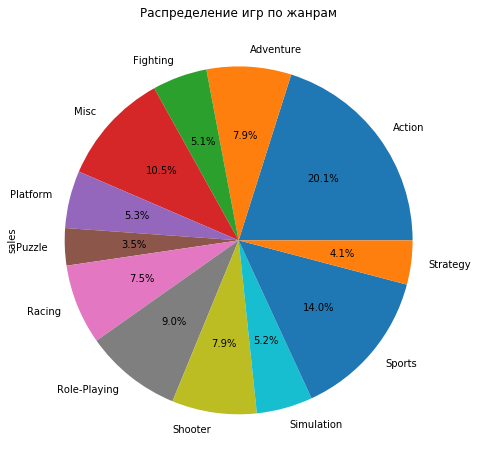

In [44]:
games.pivot_table(index='genre', values='sales', aggfunc='count').plot(kind='pie', subplots=True, figsize=(8, 8), autopct='%1.1f%%', legend=None)
plt.title('Распределение игр по жанрам')

Видим, что пятая часть всех выпущеных игр это Action. Теперь посмотрим какие жанры самые прибыльные.

In [45]:
genre_sales = games.pivot_table(index='genre', values='sales', aggfunc=('sum', 'count',)).sort_values(by='count', ascending=False)

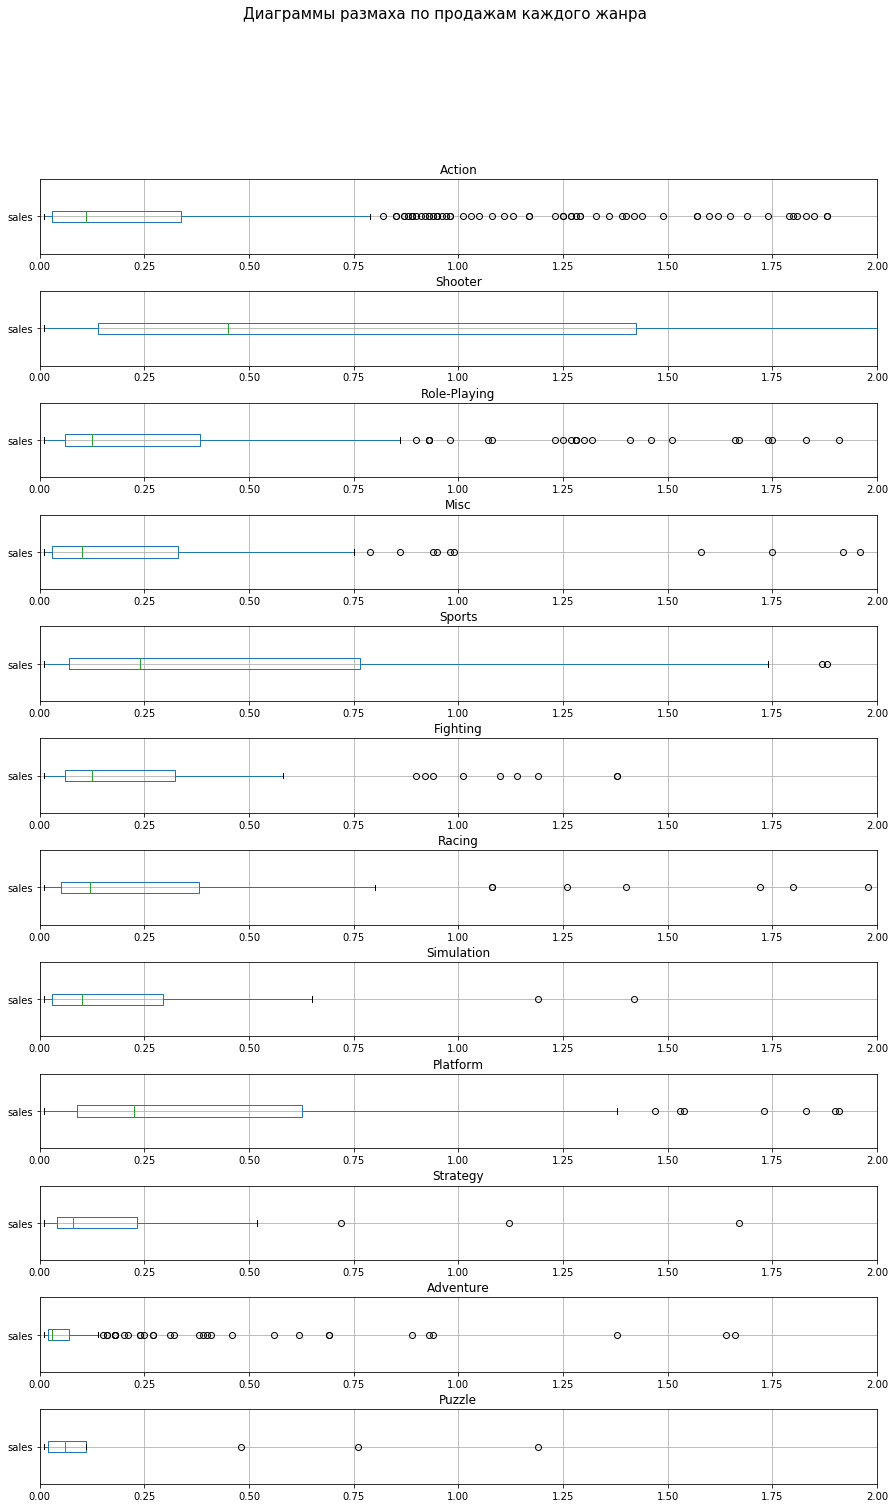

In [46]:
y = len(actual['genre'].unique())
i = 0
plt.figure(figsize=(15, 2*y)).suptitle('Диаграммы размаха по продажам каждого жанра', fontsize=15)
for genre_unique in actual['genre'].unique():
    i += 1
    plt.subplot(y, 1, i).set_title(genre_unique)
    actual.loc[actual['genre'] == genre_unique].boxplot('sales', vert=False)
    plt.xlim([0,2])
    plt.subplots_adjust(hspace=0.5)

Самые прибыльные игры выпускаются в жанре Shooter, Sports, Platform. У них большое количество игр с высокими продажами.

## Составим портрет пользователя каждого региона

Составим для каждого региона топ 5 платформ

In [47]:
platform_region = actual.pivot_table(index='platform', values=('na_sales', 'jp_sales', 'eu_sales'), aggfunc='sum')

Text(0, 0.5, 'Продажи')

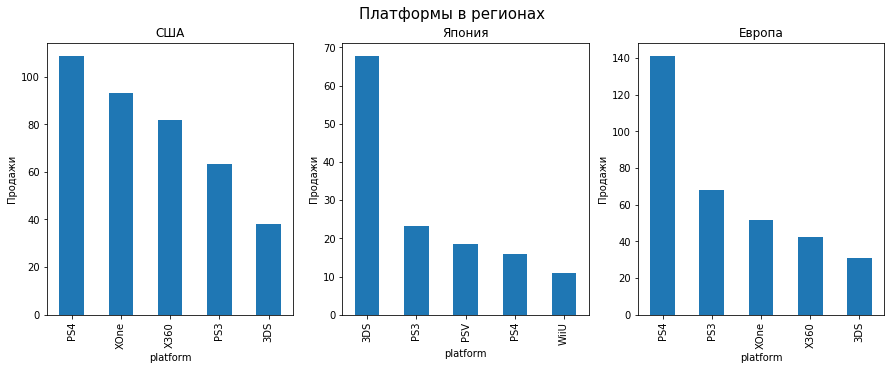

In [48]:
fig2 = plt.figure(figsize=(15, 5))
fig2.suptitle('Платформы в регионах', fontsize=15)

plt.subplot(1, 3, 1).set_title('США')
platform_region['na_sales'].sort_values(ascending=False).head(5).plot(kind='bar')
plt.ylabel('Продажи')

plt.subplot(1, 3, 2).set_title('Япония')
platform_region['jp_sales'].sort_values(ascending=False).head(5).plot(kind='bar')
plt.ylabel('Продажи')

plt.subplot(1, 3, 3).set_title('Европа')
platform_region['eu_sales'].sort_values(ascending=False).head(5).plot(kind='bar')
plt.ylabel('Продажи')

Видим, что в америке PS4 самая популярная платформа, XOne Xbox так же очень популярны. В Японии в топе только японские платформы, осталльные практически не используют. В европе больше отдают предпочтение PS, Xone Xbox тоже в топе.

Теперь посмотрим самые популярные жанры для этих регионов

In [49]:
region_genre = actual.pivot_table(index='genre', values=('na_sales', 'jp_sales', 'eu_sales'), aggfunc='sum')

Text(0, 0.5, 'Жанры')

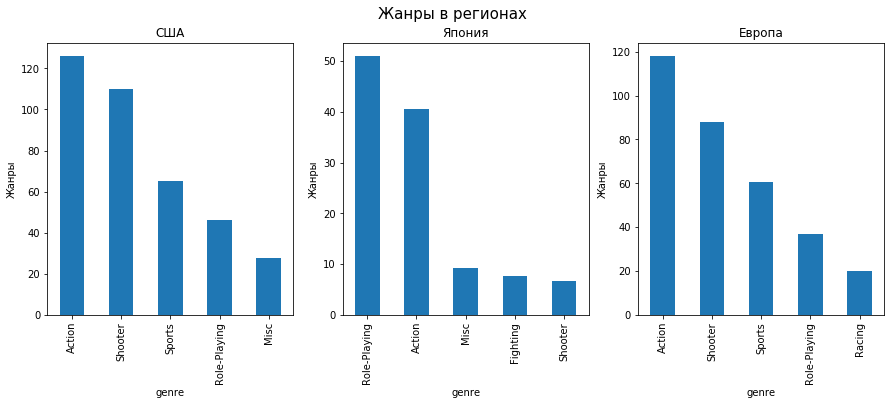

In [50]:
fig3 = plt.figure(figsize=(15, 5))
fig3.suptitle('Жанры в регионах', fontsize=15)

plt.subplot(1, 3, 1).set_title('США')
region_genre['na_sales'].sort_values(ascending=False).head(5).plot(kind='bar')
plt.ylabel('Жанры')

plt.subplot(1, 3, 2).set_title('Япония')
region_genre['jp_sales'].sort_values(ascending=False).head(5).plot(kind='bar')
plt.ylabel('Жанры')

plt.subplot(1, 3, 3).set_title('Европа')
region_genre['eu_sales'].sort_values(ascending=False).head(5).plot(kind='bar')
plt.ylabel('Жанры')

В Европе и Америка жанры  популярны практически одинаково. Самые популярные жанры это Action, Shooter, Sport. В японии другие интересы, Основной жанр это Role-Playing, но Action так же здесь популярен. Разница между жанрами в Японии и в США и Европе скорее всего из-за разных культур, все таки Европейцы и Американца имеют схожие интересы.

Теперь посмотрим как рейтинг влияет на продажи в отдельных регионах

Text(0.5, 1.0, 'Продажи по рейтингу в разных регионах')

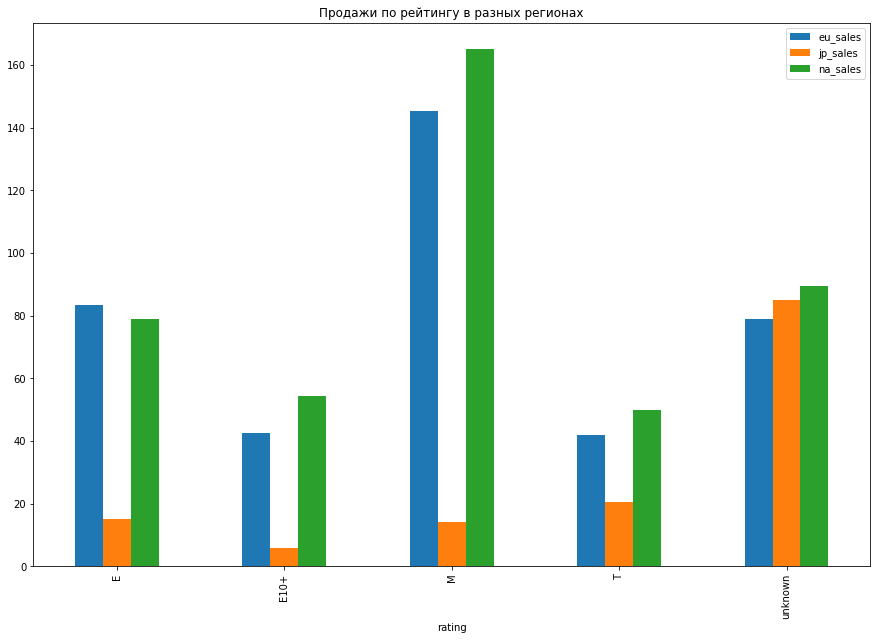

In [51]:
actual.pivot_table(index='rating', values=('na_sales', 'jp_sales', 'eu_sales'), aggfunc='sum').plot(kind='bar', figsize=(15, 10))
plt.title('Продажи по рейтингу в разных регионах')

По графику видим, как и в предыдущих выводах, что у Американцев и Европейцев схожие интересы и самые популярные игры в рейтинге M. А в Японии самые популярные игры без рейтинга и T. Можно сделать вывод, что игры создавались для своего рынка и им не нужен рейтинг для продаж в северной америке.

Вывод:
Для Американского рынка хоть на первых местах идут игры на PS3 и X360, лучше выпускать игры на PS4 и XOne, так как мы выяснили, что скоро те платформы устареют, а эти набирают популярность. Самые прибыльные это Action, Shooter и Sport. И самые популярные рейтинги E и M. Для европейского рынка, схожие препочтения, только по платформам тут еще не популярен XOne, но я преполагаю, что со временем он тоже будет пользоваться здесь спросом, так как интересы американцев и европейцев совпадают. Для Японского рынка лучше всего делать игры на платформе 3DS, все отсальные платформы устареют в ближайшее время, а PS4 здесь еще не популярна. XOne и Xbox вообще не популярны. Жанры для этого региона это RPG и Action. А рейтинг игр T и и игры без рейтинга.

## Проверка гипотез

Нам нужно проверить средние пользовательские рейтинги XOne и PC, одинаковы они или нет

Для начала просто посмотрим на средние

In [52]:
actual.query('platform == "XOne"')['user_score'].mean()

6.521428571428572

In [53]:
actual.query('platform == "PC"')['user_score'].mean()

6.269677419354839

Средние различаются, но не сильно. Теперь проверим действительно ли они разные. Нулевая гипотеза - оценки пользователей PC и XOne равны. Альтернавтивная - отличаются

In [54]:
alpha = 0.05
results = st.ttest_ind(actual.query('platform == "XOne"')['user_score'].dropna(), actual.query('platform == "PC"')['user_score'].dropna())
print('p-value:', results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не отвергаем нулевую гипотезу')

p-value: 0.14012658403611647
Не отвергаем нулевую гипотезу


Мы не отвергаем нулевую гипотезу. По средним данные приблизительно равны и статистически отвергнуть это не можем.

Теперь сравним пользовательские рейтинги жанров Action и Sports.

In [55]:
actual.query('genre == "Action"')['user_score'].mean()

6.837532133676093

In [56]:
actual.query('genre == "Sports"')['user_score'].mean()

5.238124999999999

Средние разные. Проверим с помощью нулевой гипотезы разные ли они. Нулевая гипотеза - пользовательские рейтинги этих жанров - равны. Альтернативная - разные

In [57]:
alpha = 0.05
results = st.ttest_ind(actual.query('genre == "Action"')['user_score'].dropna(), actual.query('genre == "Sports"')['user_score'].dropna())
print(results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не отвергаем нулевую гипотезу')

1.0517832389140023e-27
Отвергаем нулевую гипотезу


Отвергаем нулевую гипотезу, значит и статистически они действительно разные

## Вывод

    В 1995 году произошел скачок выпуска игр и их стало выпускаться намного больше, предположим это связано с быстрым развитием компьютерных тенологий. Выяснили, что платформы актуальны в течении 5 лет, возьмем данные только с 2013 по 2016, так как остальные года нас не интересуют. А за этот период PS3, X360, 3DS, Wii, WiiU - продажи идут на спад. Продажи игр на PSV росли до 2016 года, и в 2016 начали падать, здесь лучше не рисковать, так как платформе больше 6 лет. Продажи игр на PC плавно идут на подъем, но не так сильно как все остальные. Продажи игр на PS4 и XOne растут каждый год, эти платформы должны быть прибыльными и далее, так как они выходят только с 2013 года.
    По оценкам ситуация следующая. Ни одна игра с низкой оценкой критиков не была успешной, но часто они ставят высокую оценку провалившимся в продажах играм. Оценка пользователей разная. Они тоже часто ставят высокую оценку играм, которые провалились в продажах. И заметно чаще ошибаются, поставив низкую оценку успешым играм. ПОсмотрев на корреляию можно сказать, что зависимости между оценкаи пользователей и продажами нет, у критиков зависимость тоже слабая, но все таки выше чем у пользователей. Критики правильнее оценивают игры.
    Теперь про жанры. Пятая часть всех выпущеных игр это Action. Так же популярны Sports, Misc. Самые прибыльные игры выходят в жанрах Shooter, Sports и Platform.
    Вывод по регионам. Для Американского рынка хоть на первых местах идут игры на PS3 и X360, лучше выпускать игры на PS4 и XOne, так как мы выяснили, что скоро те платформы устареют, а эти набирают популярность. Самые интересные жанры это Action, Shooter и Sport. И самые популярные рейтинги E и M. Для европейского рынка, схожие препочтения, только по платформам тут еще не популярен XOne, но я предполагаю, что со временем он тоже будет пользоваться здесь спросом, так как интересы американцев и европейцев совпадают. Для Японского рынка лучше всего делать игры на платформе 3DS, все отсальные платформы устареют в ближайшее время, а PS4 здесь еще не популярна. XOne и Xbox вообще не популярны. Жанры для этого региона это RPG и Action. А рейтинг игр T и игры без рейтинга.
    Проверив нулевую гипотезы, можно сказать, что оценки пользователей PC и XOne равны, а пользовательские рейтинги жанров Action и Sports отличаются